In [146]:
from PIL import Image
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Checkout an image

In [36]:
filepath = 'data/dataset_dollarstreet/assets/5d4bde20cf0b3a0f3f3359fb/5d4bde20cf0b3a0f3f3359fb.jpg'

In [37]:
image = Image.open(filepath)

In [38]:
image.show()

In [39]:
image.size

(1819, 1024)

## Prepare labels
1. Only take examples with one imagenet_synonym label
2. Use only examples with the 10 most frequently occuring labels

In [57]:
df = pd.read_csv('data/dataset_dollarstreet/images_v2_imagenet_test.csv', converters={'imagenet_synonyms': eval})

In [63]:
# Take only rows where we have one label (to simplify the problem to multiclass not multilabel classification)
df_selection = df[df['imagenet_synonyms'].apply(len) == 1]

In [64]:
len(df)

4308

In [65]:
len(df_selection)

3772

In [66]:
df_selection['label'] = df_selection['imagenet_synonyms'].apply(lambda x: x[0])

/var/folders/ff/lzvrl_f53bl3fwlbvnsw4f840000gn/T/ipykernel_9961/1875909903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['label'] = df_selection['imagenet_synonyms'].apply(lambda x: x[0])


In [75]:
df_10 = df_selection[df_selection['label'].isin(df_selection['label'].value_counts()[:10].index)]

## Prepare images
1. Downscale to 128 x 128 pixels
2. Store as numpy array

In [131]:
images_matrix = np.zeros((len(df_10), 128, 128, 3), dtype='int32')
for i, (_, row) in enumerate(df_10[['label', 'imageRelPath']].iterrows()):
    filepath = pathlib.Path('data/dataset_dollarstreet/') / row['imageRelPath']
    image = Image.open(filepath)
    image = image.resize((128, 128))
    data = np.array(image, dtype='int32')
    images_matrix[i, :, :, :] = data

## Prepare data for training

In [143]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images_matrix, df_10['label'].reset_index(drop=True), stratify=df_10['label'])

In [144]:
train_images = train_images / 255
val_images = val_images / 255

In [159]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(train_labels)
train_labels = encoder.transform(train_labels)
val_labels = encoder.transform(val_labels)

In [205]:
pd.DataFrame({'label': encoder.classes_, 'index': encoder.transform(encoder.classes_)})

,label,index
0,day bed,0
1,dishrag,1
2,plate,2
3,running shoe,3
4,soap dispenser,4
5,street sign,5
6,table lamp,6
7,tile roof,7
8,toilet seat,8
9,washing machine,9


## Naive CNN without dropout
Model is overfitting a lot and best val accuracy is around 0.3, better than chance (around 0.1) but not great

In [217]:
def create_nn():
    inputs = keras.Input(shape=train_images.shape[1:])
    x = keras.layers.Conv2D(50, (3,3), activation='relu')(inputs)
    x = keras.layers.MaxPooling2D((2,2))(x) # a new maxpooling layer
    x = keras.layers.Conv2D(50, (3,3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2,2))(x) # a new maxpooling layer (same as maxpool)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(50, activation='relu')(x) # a new Dense layer
    outputs = keras.layers.Dense(10)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="dollar_street_model")
    return model

model = create_nn()
model.summary()

Model: "dollar_street_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 126, 126, 50)      1400      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 50)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 61, 61, 50)        22550     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 50)        0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 45000)     

In [218]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
compile_model(model)

In [219]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))

Epoch 1/10
28/28 [==============================] - 3s 114ms/step - loss: 2.3804 - accuracy: 0.1310 - val_loss: 2.2855 - val_accuracy: 0.1570
Epoch 2/10
28/28 [==============================] - 3s 114ms/step - loss: 2.2500 - accuracy: 0.1800 - val_loss: 2.2483 - val_accuracy: 0.1911
Epoch 3/10
28/28 [==============================] - 3s 118ms/step - loss: 2.1830 - accuracy: 0.1925 - val_loss: 2.2016 - val_accuracy: 0.2184
Epoch 4/10
28/28 [==============================] - 3s 115ms/step - loss: 2.0654 - accuracy: 0.2631 - val_loss: 2.1950 - val_accuracy: 0.2355
Epoch 5/10
28/28 [==============================] - 3s 113ms/step - loss: 1.9060 - accuracy: 0.3303 - val_loss: 2.2142 - val_accuracy: 0.2662
Epoch 6/10
28/28 [==============================] - 3s 118ms/step - loss: 1.5860 - accuracy: 0.4624 - val_loss: 2.2695 - val_accuracy: 0.2457
Epoch 7/10
28/28 [==============================] - 3s 114ms/step - loss: 1.2410 - accuracy: 0.5763 - val_loss: 2.3153 - val_accuracy: 0.2526
Epoch 

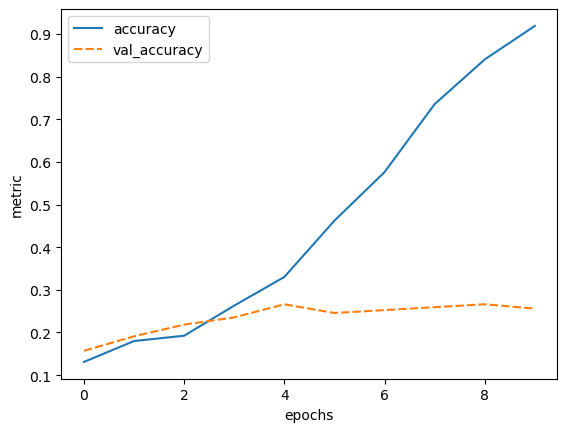

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics(str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")
plot_history(history, ['accuracy', 'val_accuracy'])

## Use dropout to counteract overfitting
Less overfitting, but it does not really improve the score much...

In [221]:
def create_nn_with_dropout():
    inputs = keras.Input(shape=train_images.shape[1:])
    x = keras.layers.Conv2D(50, (3, 3), activation='relu')(inputs)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(50, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(50, (3, 3), activation='relu')(x)
    x = keras.layers.Dropout(0.8)(x) # This is new!
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    outputs = keras.layers.Dense(10)(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar_model")
    return model

model_dropout = create_nn_with_dropout()
model_dropout.summary()

Model: "cifar_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_34 (Conv2D)          (None, 126, 126, 50)      1400      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 63, 63, 50)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 61, 61, 50)        22550     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 30, 30, 50)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 50)        

In [222]:
compile_model(model_dropout)

history = model_dropout.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))

Epoch 1/10
28/28 [==============================] - 4s 129ms/step - loss: 2.3084 - accuracy: 0.1162 - val_loss: 2.2969 - val_accuracy: 0.1570
Epoch 2/10
28/28 [==============================] - 4s 128ms/step - loss: 2.2844 - accuracy: 0.1424 - val_loss: 2.2679 - val_accuracy: 0.1741
Epoch 3/10
28/28 [==============================] - 4s 129ms/step - loss: 2.2507 - accuracy: 0.1651 - val_loss: 2.2384 - val_accuracy: 0.1638
Epoch 4/10
28/28 [==============================] - 4s 126ms/step - loss: 2.2019 - accuracy: 0.2153 - val_loss: 2.2066 - val_accuracy: 0.1945
Epoch 5/10
28/28 [==============================] - 4s 129ms/step - loss: 2.1025 - accuracy: 0.2642 - val_loss: 2.1302 - val_accuracy: 0.2355
Epoch 6/10
28/28 [==============================] - 4s 129ms/step - loss: 1.8985 - accuracy: 0.3235 - val_loss: 2.1091 - val_accuracy: 0.2594
Epoch 7/10
28/28 [==============================] - 4s 127ms/step - loss: 1.7087 - accuracy: 0.4191 - val_loss: 2.1671 - val_accuracy: 0.3038
Epoch 

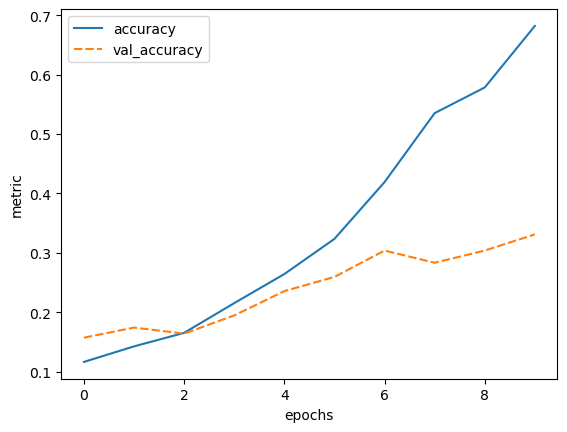

In [223]:
plot_history(history, ['accuracy', 'val_accuracy'])

## Use a pretrained neural network
More than doubles the accuracy score!

In [209]:
import tensorflow as tf

# input tensor
inputs = keras.Input(train_images.shape[1:])

# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  160,
                                                                  160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [210]:
train_images.shape, train_labels.shape

((878, 128, 128, 3), (878,))

In [211]:
# load base model
base_model = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

# set base model training off
base_model.trainable = False

# add top layers
out = base_model.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.5)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.5)(out)
out = keras.layers.Dense(10)(out)

CALLBACKS = []
CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

optimizer = 'adam'

# model compile
model = keras.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# train
history = model.fit(x=train_images,
                    y=train_labels,
                    batch_size=32,
                    epochs=20,
                    callbacks=CALLBACKS,
                    validation_data=(val_images, val_labels))

Epoch 1/20
28/28 [==============================] - 15s 466ms/step - loss: 2.7869 - accuracy: 0.1606 - val_loss: 2.3442 - val_accuracy: 0.2048
Epoch 2/20
28/28 [==============================] - 12s 441ms/step - loss: 2.2113 - accuracy: 0.2768 - val_loss: 1.8767 - val_accuracy: 0.3413
Epoch 3/20
28/28 [==============================] - 12s 429ms/step - loss: 1.9086 - accuracy: 0.3462 - val_loss: 1.6274 - val_accuracy: 0.4608
Epoch 4/20
28/28 [==============================] - 12s 430ms/step - loss: 1.7560 - accuracy: 0.4032 - val_loss: 1.4563 - val_accuracy: 0.5461
Epoch 5/20
28/28 [==============================] - 13s 458ms/step - loss: 1.6596 - accuracy: 0.4226 - val_loss: 1.3540 - val_accuracy: 0.5802
Epoch 6/20
28/28 [==============================] - 12s 439ms/step - loss: 1.4722 - accuracy: 0.4954 - val_loss: 1.3012 - val_accuracy: 0.6177
Epoch 7/20
28/28 [==============================] - 12s 440ms/step - loss: 1.3973 - accuracy: 0.5330 - val_loss: 1.2530 - val_accuracy: 0.6314

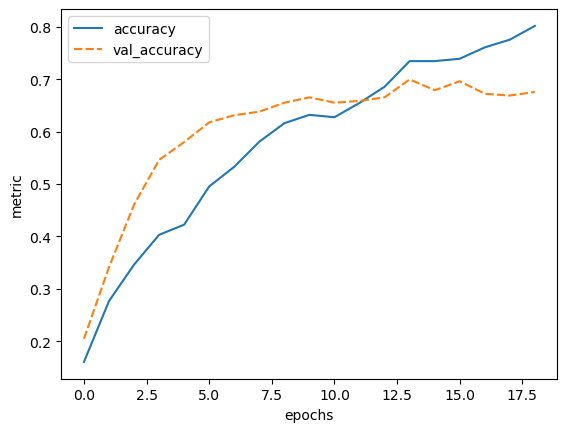

In [212]:
plot_history(history, ['accuracy', 'val_accuracy'])

## Compare with dense model
Val accuracy only reaches 0.2, so clearly a CNN works better on this dataset!

In [202]:
def create_dense_model():
    inputs = keras.Input(shape=train_images.shape[1:])
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(50, activation='relu')(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    outputs = keras.layers.Dense(10)(x)
    return keras.models.Model(inputs=inputs, outputs=outputs,
                              name='dense_model')

dense_model = create_dense_model()
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 flatten_22 (Flatten)        (None, 49152)             0         
                                                                 
 dense_54 (Dense)            (None, 50)                2457650   
                                                                 
 dense_55 (Dense)            (None, 50)                2550      
                                                                 
 dense_56 (Dense)            (None, 10)                510       
                                                                 
Total params: 2460710 (9.39 MB)
Trainable params: 2460710 (9.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
28/28 [==============================] - 0s 7ms/step - loss: 5.0851 - accuracy: 0.1128 - val_loss: 2.4295 - val_accuracy: 0.1263
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 2.3235 - accuracy: 0.1629 - val_loss: 2.2842 - val_accuracy: 0.1706
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 2.2568 - accuracy: 0.1834 - val_loss: 2.3039 - val_accuracy: 0.1741
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 2.2420 - accuracy: 0.1834 - val_loss: 2.2431 - val_accuracy: 0.1433
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 2.2182 - accuracy: 0.1777 - val_loss: 2.2584 - val_accuracy: 0.1741
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 2.2076 - accuracy: 0.1720 - val_loss: 2.3722 - val_accuracy: 0.1604
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 2.2426 - accuracy: 0.1663 - val_loss: 2.2475 - val_accuracy: 0.1570
Epoch 8/20
28/28 [==

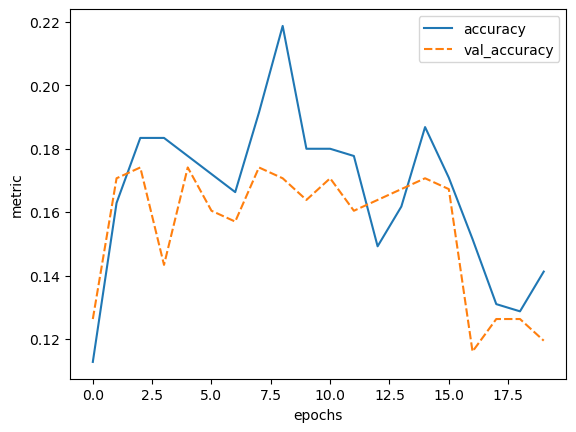

In [203]:
compile_model(dense_model)
history = dense_model.fit(train_images, train_labels, epochs=20,
                    validation_data=(val_images, val_labels))
plot_history(history, ['accuracy', 'val_accuracy'])